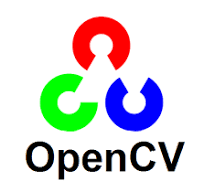

# ***Train custom Face Mask Detector by YOLOv3 DarkNet***

We will train the custom YOLO detector for Mask detection on the Face and save to the ONNX format for production using.

### ***Check GPU resources***

In [ ]:
!nvidia-smi

### ***Import libraries***

In [2]:
# Import Libraries
import os, sys, time, subprocess, cv2, io

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageEnhance, ImageDraw

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib

import requests
import zipfile

from IPython.display import YouTubeVideo, display, HTML, Video
from base64 import b64encode

%matplotlib inline

In [3]:
matplotlib.rcParams['figure.figsize'] = (8.0,8.0)
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bilinear'

## ***Assignment***

# Introduction

## Project content
1. Overview
2. Expected Output
3. Data
4. Task
5. Submission
6. Marks Distribution

## ***1. Overview***

In the last lesson, we have learned how to train a custom Object Detector using YOLO v3 network for a single object. In this project, you will extend that learning by building a 2-Class Object Detector using Yolo v3 as well as the more recent Yolo v4. In the process, you will also learn how to browse other GitHub repositories and find out relevant information to complete your task.

Since Covid-19 has had such a huge impact on our lives, we will build a Mask and No-mask Detector. So, the classes are:

- Class 0 - Face with Mask
- Class 1 - Face without Mask

## ***2. Expected Output***

Given below are the expected outputs of the test images and videos.

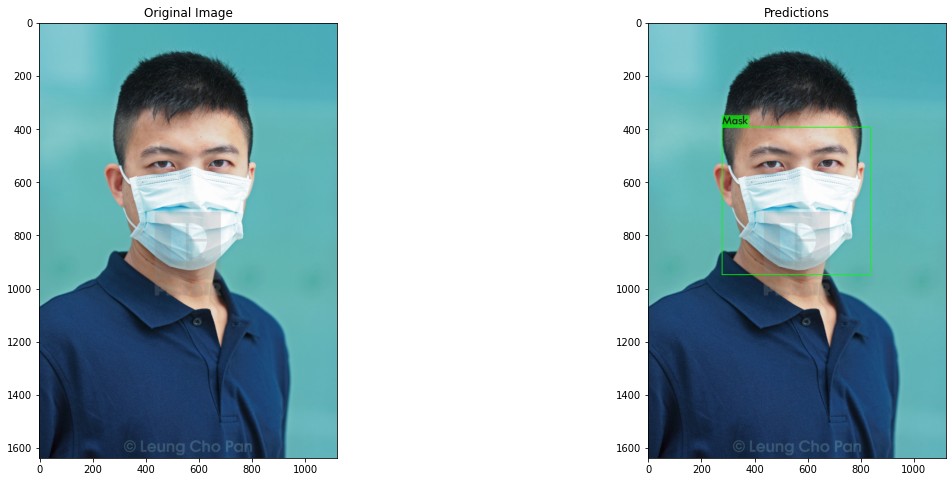
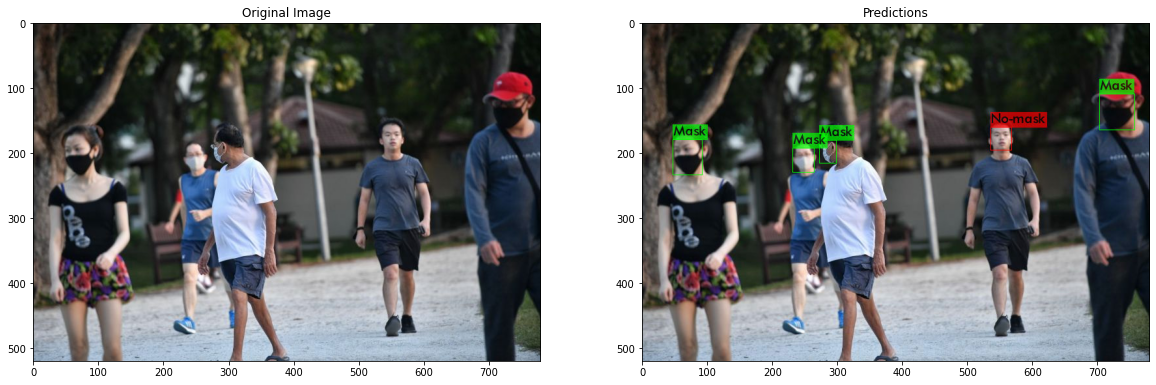
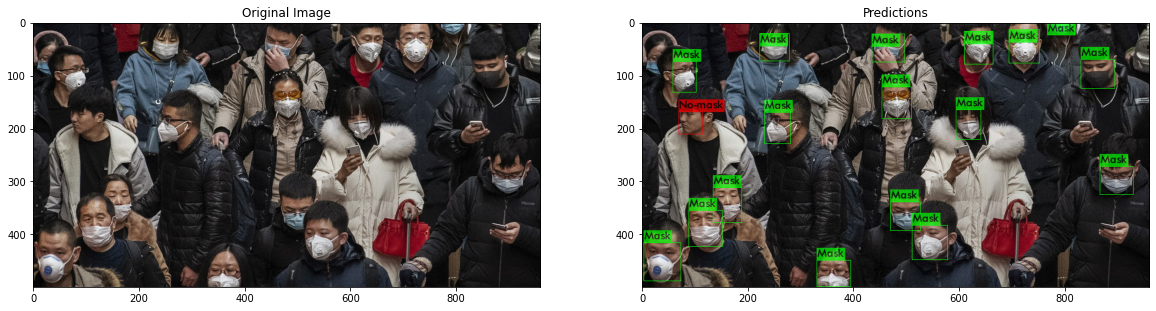
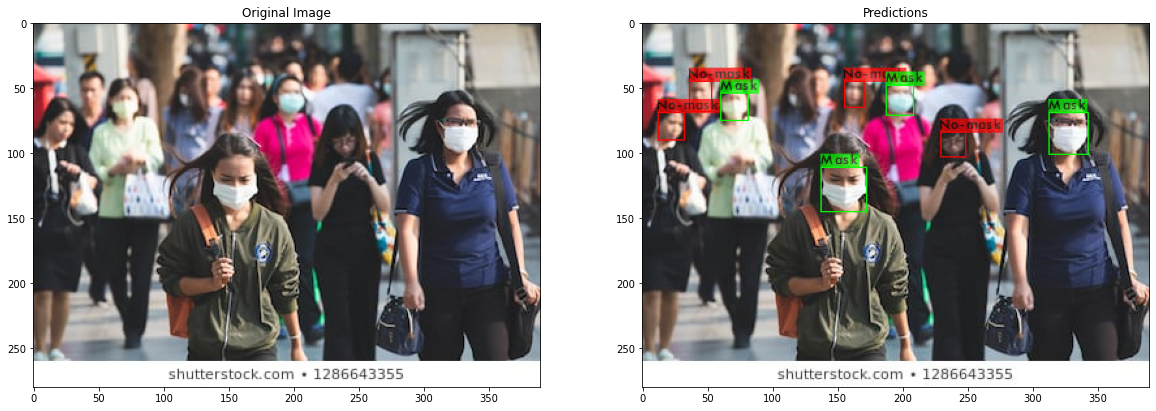

----------------------------------------------------------------------------------

### **Video**

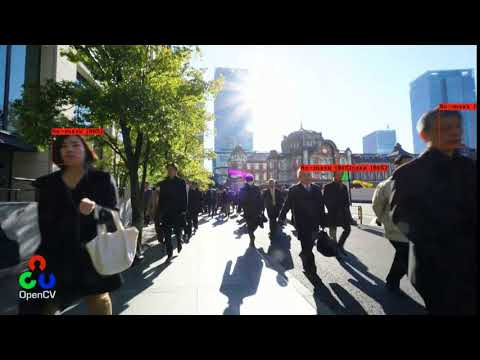

In [4]:
# Show used video
video = YouTubeVideo("1982JxViLig", width=1024, height=640)
display(video)

## ***Path to the train, test dataset***

In [5]:
# Paths for data connection 

TRAIN_DATA_PATH = os.path.join('/', 'kaggle','input','face-mask-detection-opencv-university-dataset')
TEST_DATA_PATH = os.path.join('/', 'kaggle','input','face-mask-detection-test-opencv-university','test_dataset','images')

WORK_DIRECTORY = os.path.join('/', 'kaggle','working')

## ***Clone the DarkNet Repository***

We will use Alexey's darknet fork which has many modifications and improvements and is actively maintained by him.

In [6]:
!git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15851, done.
remote: Total 15851 (delta 0), reused 0 (delta 0), pack-reused 15851
Receiving objects: 100% (15851/15851), 14.37 MiB | 22.36 MiB/s, done.
Resolving deltas: 100% (10683/10683), done.


## ***Compile DarkNet***

In [7]:
%cd /kaggle/working/darknet

/kaggle/working/darknet


In [8]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

print("Building. . . It might take 2-3 minutes")

!make &> build_log.txt

Building. . . It might take 2-3 minutes


# ***Download Code for YOLO Training***
We have shared the code for training in the link below. Explanation of each file follows next.

In [13]:
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_Project4/main/models/yolov3/class.names" -O class.names
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_Project4/main/models/yolov3/yolov3-facemaskdetect-setup.data" -O yolov3-facemaskdetect-setup.data
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_Project4/main/models/yolov3/yolov3-facemaskdetect-test.cfg" -O yolov3-facemaskdetect-test.cfg
!wget "https://raw.githubusercontent.com/RadimKozl/OpenCV_Project4/main/models/yolov3/yolov3-facemaskdetect-train.cfg" -O yolov3-facemaskdetect-train.cfg

--2024-07-24 10:16:41--  https://raw.githubusercontent.com/RadimKozl/OpenCV_Project4/main/models/yolov3/class.names
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12 [text/plain]
Saving to: 'class.names'

class.names         100%[===================>]      12  --.-KB/s    in 0s      

2024-07-24 10:16:41 (242 KB/s) - 'class.names' saved [12/12]

--2024-07-24 10:16:42--  https://raw.githubusercontent.com/RadimKozl/OpenCV_Project4/main/models/yolov3/yolov3-facemaskdetect-setup.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 95

# ***Download weights for Convolutional backbone***
When you train your own object detector, it is a good idea to leverage existing models trained on very large datasets even though the large dataset may not contain the object you are trying to detect. This process is called transfer learning.

Instead of learning from scratch, we use a pre-trained model which contains convolutional weights trained on ImageNet. Using these weights as our starting weights, our network can learn faster. We will use the pre-trained convolutional backbone. 

We will download the weights file from our server as the author's server seemed slow. If you face any issues, you can download the file from the link given in the code below.

In [14]:
!wget "https://pjreddie.com/media/files/darknet53.conv.74" -O darknet53.conv.74

--2024-07-24 10:25:20--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: 'darknet53.conv.74'

darknet53.conv.74   100%[===================>] 154.96M  36.7MB/s    in 4.6s    

2024-07-24 10:25:25 (33.3 MB/s) - 'darknet53.conv.74' saved [162482580/162482580]



# ***Prepare dataset files***
We need to create a txt file which contains the path to the images. These files will be used while setting up the training. 

The data is split into train and test in the ratio of 80:20. So, we will use 80% of the data for training and the rest for testing after a few iterations of training.

In [15]:
import random
import os
import subprocess
import sys

image_dir = "/kaggle/input/face-mask-detection-opencv-university-dataset"
f_val = open("/kaggle/working/darknet/data_test.txt", 'w')
f_train = open("/kaggle/working/darknet/data_train.txt", 'w')

path, dirs, files = next(os.walk(image_dir))
data_size = len(files)

ind = 0
data_test_size = int(0.2 * data_size)
test_array = random.sample(range(data_size), k=data_test_size)

for f in os.listdir(image_dir):
    if(f.split(".")[-1] == "jpg"):
        ind += 1
        
        if ind in test_array:
            f_val.write(image_dir+'/'+f+'\n')
        else:
            f_train.write(image_dir+'/'+f+'\n')

f_train.close()
f_val.close()

# ***Start Training***
For starting training using darknet, we need to execute the following command. Here we are specifying the
1. path to the setup file, 
1. path to config file, 
1. path to convolutional weights file 

and also passing some flags such as:

- **`dont_show`** which wont display the graphs. This is required for Colab since it does not have a display and it will crash if it tries to display, not if you run the notebook on your local system.
- **`map`** - this will calculate mAP - mean average precision for the test data which we have specified using the data_test.txt file which contains 20% of our data.

In [ ]:
!./darknet detector train yolov3-facemaskdetect-setup.data yolov3-facemaskdetect-train.cfg ./darknet53.conv.74 -dont_show -map 2> train_log.txt